In [4]:
# imports
# python standard library
import os
import re
import matplotlib.pyplot as plt

# dependencies
# standard scientific packages
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.ndimage import uniform_filter as unifilt
from scipy.ndimage import gaussian_filter1d as gfilt

# from https://github.com/fncokg/pymultitaper
# (cross-checked against chronux MATLAB package)
from pymultitaper import multitaper_spectrogram

# from my GRID Lab repo
# https://github.com/jtmiles/GRID_lab_python
from iEEG_utils.processing import filtering
from iEEG_utils.loading import read_data

# folder with all of the data
fstr = r"INSERT WHERE iEEG DATA ARE STORED HERE"
fstr = r"C:\Users\jmile3\Desktop\PAF_INT_test\Miles_Weaver_Webb_Ojemann_2025_iEEGData"
# string pattern where individual subject data are stored "subXX"
pattern = re.compile(r"sub[0-9]{2}_")
# just the folders of interest
subfldrs = list(filter(pattern.match,os.listdir(fstr)))

In [5]:
# process data from each subj
# set some parameters that will be used for processing
#####
t_res = 1/4 # time between spectra calculations (seconds)
f_res = 1/2 # frequency bin size for spectra (Hz)
t_win = 1 # in seconds
fmin = 0.5 # minimum frequency to save
fmax = 100 # max frequency to save (should be below 256)
resrate = 1024 # common rate to resample all data to
lpfreq = 150 # frequency for LFP low pass filter
cols = ['ID','age','region','time'] # metadata to add to table 
#####

# loop through participants
all_spect = []
for sub in range(len(subfldrs)):
    print(subfldrs[sub])
    sID = subfldrs[sub][-6::]
    # load the montage (channels getting analyzed)
    montf = [s for s in os.listdir(fstr+"\\"+subfldrs[sub]) if "montage" in s]
    assert len(montf) <= 1, "multiple montage files?"
    if len(montf) == 0:
        print('no montage file...')
        # NOTE - instead of an error this loads in ALL DATA
        chs = None
    else:
        submont = pd.read_csv(fstr+"\\"+subfldrs[sub]+"\\"+montf[0])
        chs = list(submont.ch.dropna())

    # load in raw data
    [origfs,data] = read_data.load_iEEG(fstr+"\\"+subfldrs[sub],chs=list(submont.ch.dropna()))
    origts = np.linspace(1/origfs,(1/origfs)*data.shape[0],data.shape[0])
    # one subject had long resting state, only take 10 minutes
    if sID == "ecb43e":
            data = data.loc[origts<=600,:];
            origts = origts[origts<=600];
    
    regs = submont.dropna(how='any').region.unique()
    subjdata = []
    age = float(submont.age[0])
    # calculate spectra for each region (generates time-frequency matrix)
    for r in regs:
        # get channels, flip ixs to get correct channel orientation for (later) diff subtraction
        chs = submont.ch[submont.region==r] #.sort_index(ascending=False).to_numpy()
        regdata = data.loc[:,chs]
        
        # remove baseline drift with 1 second rolling average
        hpfdata = regdata-regdata.rolling(window=int(origfs),min_periods=int(origfs/2),center=True).mean()
        # filter 60 Hz line noise, harmonics, and lowpass. then resample and normalize traces
        [ts, normdata,filt_wins] = filtering.filt_resample(hpfdata, origfs, resrate, lpfreq=lpfreq, norm='zscore')
        # bipolar re-referencing pair from region
        bip_ch = np.squeeze(np.diff(normdata,axis=1))
        # calculate spectra
        # spectra,f,sts = filtering.calc_spectra(bip_ch, resrate, t_res=t_res, f_res=f_res)
        f,sts,spectra = multitaper_spectrogram(bip_ch,resrate,time_step=t_res,window_length=t_win,NW=3,
                                               detrend='off',freq_range=[0.5, 100],nfft=2*t_win*resrate,
                                               db_scale=False,boundary_pad=False)
        subf = f[(f>=fmin) & (f<=fmax)]
        subspec = spectra.T[:,(f>=fmin) & (f<=fmax)]
        regdf = pd.DataFrame({str(subf[i]):subspec[:,i] for i in range(len(subf))})
        regdf.loc[:,'ID'] = sID
        regdf.loc[:,'age'] = age
        regdf.loc[:,'region'] = r
        regdf.loc[:,'time'] = sts
        regdf = regdf[cols + [c for c in regdf.columns if c not in cols]]
        subjdata.append(regdf)    
    subjdata = pd.concat(subjdata)
    all_spect.append(subjdata)
    
all_spect = pd.concat(all_spect)

sub01_86b2be
sub02_d419f2
sub03_4ac2b6
sub04_71944e
sub05_b387f2
sub06_854490
sub07_9d10c8
sub08_a9952e
sub09_a29aee
sub10_979eab
sub11_693ffd
sub12_fca96e
sub13_ecb43e


979eab


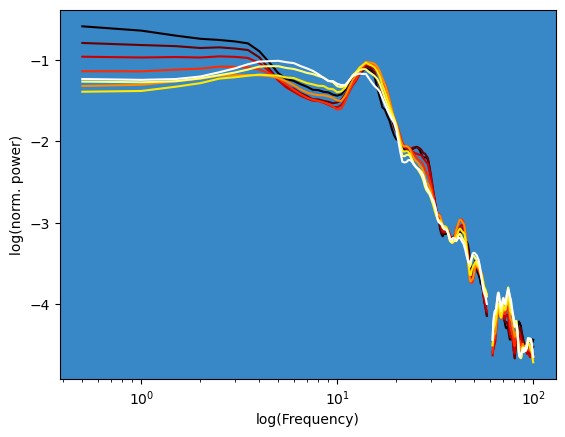

In [6]:
# check data
import random
randID = random.choice(all_spect.ID.unique())
filtdata = (all_spect.ID==randID) #& (all_spect.region == "Supramarginal_gyrus")
freqstr = [str(f_) for f_ in f[(f>=fmin)&(f<=fmax)]]
filttab = all_spect.loc[filtdata,:].reset_index(drop=True)
filtspect = filttab.loc[:,freqstr].to_numpy()
smoothspect = unifilt(np.log10(filtspect), [5,3], mode="nearest", )
smoothspect[:,(subf>=58.5)&(subf<=61.5)] = np.nan
plt.close('all')
print(randID)

# look at some examples of (smoothed) power spectra
nspec = 8
s0 = random.randint(1,np.shape(smoothspect)[0])
plotcmap = plt.cm.hot(np.linspace(0,1,nspec))
fig,ax = plt.subplots()
ax.set_prop_cycle('color',plotcmap)
ax.plot(f[(f>0)&(f<=100)], smoothspect[s0:s0+nspec,:].T)
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_facecolor([0.22, 0.53, 0.78])
ax.set_xlabel("log(Frequency)")
ax.set_ylabel("log(norm. power)")
plt.show()

In [7]:
# spectra saved linear (pre-log10 transform)
all_spect.to_csv(fstr+r"\restingstate_spectra.csv", index=False)